<table class="ee-notebook-buttons" align="left">
    <td><a target="_blank"  href="https://github.com/giswqs/geemap/tree/master/examples/template/template.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td>
    <td><a target="_blank"  href="https://nbviewer.jupyter.org/github/giswqs/geemap/blob/master/examples/template/template.ipynb"><img width=26px src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Jupyter_logo.svg/883px-Jupyter_logo.svg.png" />Notebook Viewer</a></td>
    <td><a target="_blank"  href="https://colab.research.google.com/github/giswqs/geemap/blob/master/examples/template/template.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a></td>
</table>

In [ ]:
# Installs geemap package
import subprocess

try:
    import geemap
except ImportError:
    print("Installing geemap ...")
    subprocess.check_call(["python", "-m", "pip", "install", "geemap"])

Installing geemap ...


In [ ]:
import ee
import geemap
import os
import pandas as pd
import seaborn as sns, numpy as np
from pylab import *
from matplotlib.pyplot import plot, show, draw, figure, cm
import matplotlib.pyplot as plt

In [ ]:
Map = geemap.Map(center=[40, -100], zoom=4)
Map

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=95psNvYygpbNf_sczoc63xNLC0X9nNQcbq26icf6UVc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWj0cbIZFzuAcmuWHpA98gv0CZYmPYOB3f8_UJDw21Weo_5pSw1FrxY

Successfully saved authorization token.


Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Add Earth Engine dataset
geometry = ee.FeatureCollection(
        [ee.Feature(
            ee.Geometry.Polygon(
                [[[79.13203579965962, 19.85569590925576],
                  [79.13203579965962, 19.848833868667082],
                  [79.1379581171645, 19.848833868667082],
                  [79.1379581171645, 19.85569590925576]]]))])

evistudy = ee.Geometry.Polygon(
        [[[79.1151672297528, 19.868029319174227],
          [79.1151672297528, 19.837029093779364],
          [79.15344771681335, 19.837029093779364],
          [79.15344771681335, 19.868029319174227]]])

studyArea = evistudy

In [ ]:
imageCollection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
  .filterBounds(studyArea)

def maskL8sr(imageCollection):
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5

  qa = imageCollection.select('pixel_qa')

  mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
      .And(qa.bitwiseAnd(cloudsBitMask).eq(0))

  return imageCollection.updateMask(mask).divide(10000) \
      .select("B[0-9]*") \
      .copyProperties(imageCollection, ["system:time_start"])


stepList = ee.List.sequence(2014,2021)


def func_jcn(year):
  startDate = ee.Date.fromYMD(year,1,1)
  endDate = ee.Date.fromYMD(year,12,31)
  composite_i = imageCollection.filterDate(startDate, endDate) \
                        .map(maskL8sr) \
                        .median() \
                        .set('system:time_start',startDate)
  return composite_i

filterCollection = stepList.map(func_jcn)

yearlyComposites = ee.ImageCollection(filterCollection)
# print(yearlyComposites, 'Masked and Filtered Composites')

visParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.3,
  'gamma': 1.4,
}



In [ ]:
# #----------------------------------------------------EVI Index-------------------------------------------

# EVI = 2.5 * ((NIR - Red) / (NIR + 6 * Red – 7.5 * Blue + 1))
def evi(img):
  eviImg = img.select(['B5','B4','B2'],['nir','red','blue'])
  eviImg = eviImg.expression(
    '(2.5 * ((NIR - RED)) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
      'NIR': eviImg.select('nir'),
      'RED': eviImg.select('red'),
      'BLUE': eviImg.select('blue')
    }).rename('EVI')
  return img.addBands(eviImg)

def func_hox(image):
  return evi(image)

yearlyComposites = yearlyComposites.map(func_hox)


# print(yearlyComposites, 'With EVI as Band')

# Create image collection of yearly composites, selecting the EVI band.
eviCollection = yearlyComposites.select('EVI')


In [ ]:
out_dir = '/content/drive/MyDrive/WII/GEE'
out_dem_stats = os.path.join(out_dir, 'EVI_mean.csv')  

In [ ]:
geemap.zonal_statistics(eviCollection, geometry, out_dem_stats, statistics_type='MEAN', scale=30)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/WII/GEE/EVI_mean.csv


In [ ]:
EVI_mean_df = pd.read_csv('/content/drive/MyDrive/WII/GEE/EVI_mean.csv')
EVI_mean_df = EVI_mean_df.rename(columns = {'0_EVI': '2014', '1_EVI': '2015', '2_EVI': '2016', '3_EVI': '2017',
                                            '4_EVI': '2018', '5_EVI': '2019', '6_EVI': '2020', '7_EVI': '2021' }, inplace = False)
EVI_mean_df = EVI_mean_df.drop('system:index', axis = 1)
EVI_mean_df = EVI_mean_df.transpose()
EVI_mean_df['Year'] = EVI_mean_df.index
EVI_mean_df['EVI'] = EVI_mean_df[0]
EVI_mean_df

,0,Year,EVI
2014,0.228254,2014,0.228254
2015,0.206920,2015,0.206920
2016,0.100285,2016,0.100285
2017,0.097806,2017,0.097806
2018,0.068488,2018,0.068488
2019,0.047195,2019,0.047195
2020,0.059513,2020,0.059513
2021,0.044568,2021,0.044568


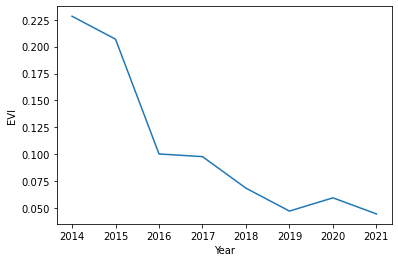

In [ ]:
sns.lineplot(data=EVI_mean_df, x="Year", y="EVI")

In [ ]:
# #----------------------------------------------------NDBI Index-------------------------------------------

# NDBI = (SWIR – NIR) / (SWIR + NIR)
def ndbi(img):
  ndbiImg = img.select(['B7','B5'],['swir','nir'])
  ndbiImg = ndbiImg.expression(
    '((SWIR - NIR) / (SWIR + NIR))', {
      'NIR': ndbiImg.select('nir'),
      'SWIR': ndbiImg.select('swir')
    }).rename('NDBI')
  return img.addBands(ndbiImg)



def func_otl(image):
  return ndbi(image)

yearlyComposites = yearlyComposites.map(func_otl)
# print(yearlyComposites, 'With NDBI as Band')

# Create image collection of yearly composites, selecting the EVI band.
ndbiCollection = yearlyComposites.select('NDBI')


In [ ]:
out_dir = '/content/drive/MyDrive/WII/GEE'
out_dem_stats = os.path.join(out_dir, 'NDBI_mean.csv')  

geemap.zonal_statistics(ndbiCollection, geometry, out_dem_stats, statistics_type='MEAN', scale=30)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/WII/GEE/NDBI_mean.csv


In [ ]:
NDBI_mean_df = pd.read_csv('/content/drive/MyDrive/WII/GEE/NDBI_mean.csv')
NDBI_mean_df = NDBI_mean_df.rename(columns = {'0_NDBI': '2014', '1_NDBI': '2015', '2_NDBI': '2016', '3_NDBI': '2017',
                                            '4_NDBI': '2018', '5_NDBI': '2019', '6_NDBI': '2020', '7_NDBI': '2021' }, inplace = False)
NDBI_mean_df = NDBI_mean_df.drop('system:index', axis = 1)
NDBI_mean_df = NDBI_mean_df.transpose()
NDBI_mean_df['Year'] = NDBI_mean_df.index
NDBI_mean_df['NDBI'] = NDBI_mean_df[0]
NDBI_mean_df

,0,Year,NDBI
2014,-0.244481,2014,-0.244481
2015,-0.199464,2015,-0.199464
2016,0.010272,2016,0.010272
2017,0.067748,2017,0.067748
2018,0.071742,2018,0.071742
2019,0.164532,2019,0.164532
2020,0.135992,2020,0.135992
2021,0.162798,2021,0.162798


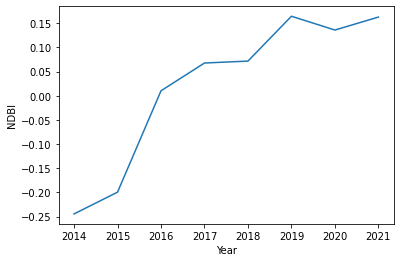

In [ ]:
sns.lineplot(data=NDBI_mean_df, x="Year", y="NDBI")

In [ ]:
#------------------------------------Vegetation Graph-----------------------------------

# Load Landsat 7 Collection 1 Tier 1 8-Day NDVI Composite
collectionl7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_8DAY_NDVI").select('NDVI')

out_dir = '/content/drive/MyDrive/WII/GEE'
out_dem_stats = os.path.join(out_dir, 'NDVI_mean_Landsat7.csv')  

geemap.zonal_statistics(collectionl7, geometry, out_dem_stats, statistics_type='MEAN', scale=30)

Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/WII/GEE/NDVI_mean_Landsat7.csv


In [ ]:
NDVI_mean_df = pd.read_csv('/content/drive/MyDrive/WII/GEE/NDVI_mean_Landsat7.csv')
NDVI_mean_df = NDVI_mean_df.drop('system:index', axis = 1)
NDVI_mean_df = NDVI_mean_df.dropna(axis= 1)
NDVI_mean_df = NDVI_mean_df.transpose()
NDVI_mean_df['index'] = NDVI_mean_df.index
NDVI_mean_df['NDVI'] = NDVI_mean_df[0]
result = NDVI_mean_df.reset_index(drop = True)
result[['date', 'indices']] = result['index'].str.split('_', 1, expand=True)
result['Year'] = result['date'].apply(lambda x: x[0:4])
result = result.drop(['index', 'date', 'indices'], axis = 1)
result

,0,NDVI,year
0,0.188913,0.188913,1999
1,0.464929,0.464929,1999
2,0.358827,0.358827,2000
3,0.190666,0.190666,2000
4,0.096719,0.096719,2000
...,...,...,...
279,0.025884,0.025884,2021
280,0.017769,0.017769,2021
281,0.011897,0.011897,2021
282,0.070888,0.070888,2021


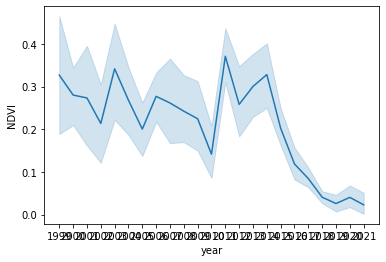

In [ ]:
sns.lineplot(data=result, x="Year", y="NDVI")